In [287]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [288]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='fMw50IHOXM4Ow8bwDaiFDYBIozgf4RT622g_7YvGOYm5',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'crudeoilpriceprediction-donotdelete-pr-punvcotrkuvktd'
object_key = 'Crude Oil Prices Daily.xlsx'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']

data = pd.read_excel(body.read())
data.head()


,Date,Closing Value
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


In [289]:
data.isnull().any()


Date             False
Closing Value     True
dtype: bool

In [290]:
data.dropna(axis=0,inplace=True)


In [291]:
data.isnull().sum()


Date             0
Closing Value    0
dtype: int64

In [292]:
data_oil=data.reset_index()['Closing Value']
data_oil


0       25.56
1       26.00
2       26.53
3       25.85
4       25.87
        ...  
8211    73.89
8212    74.19
8213    73.05
8214    73.78
8215    73.93
Name: Closing Value, Length: 8216, dtype: float64

In [293]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data_oil=scaler.fit_transform(np.array(data_oil).reshape(-1,1))


In [294]:
data_oil


array([[0.11335703],
       [0.11661484],
       [0.12053902],
       ...,
       [0.46497853],
       [0.47038353],
       [0.47149415]])

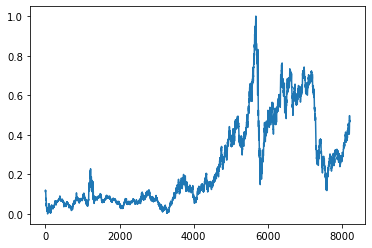

In [295]:
plt.plot(data_oil)


In [296]:
training_size=int(len(data_oil)*0.65)
test_size=len(data_oil)-training_size
train_data,test_data=data_oil[0:training_size,:],data_oil[training_size:len(data_oil),:1]


In [297]:
training_size,test_size


(5340, 2876)

In [298]:
train_data.shape


(5340, 1)

In [299]:
def create_dataset(dataset,time_step=1):
  dataX,dataY=[],[]
  for i in range(len(dataset)-time_step-1):
    a=dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX),np.array(dataY)


In [300]:
time_step=10
x_train,y_train=create_dataset(train_data,time_step)
x_test,y_test=create_dataset(test_data,time_step)


In [301]:
print(x_train.shape),print(y_train.shape)


(5329, 10)
(5329,)


(None, None)

In [302]:
print(x_test.shape),print(y_test.shape)


(2865, 10)
(2865,)


(None, None)

In [303]:
x_train

array([[0.11335703, 0.11661484, 0.12053902, ..., 0.10980305, 0.1089886 ,
        0.11054346],
       [0.11661484, 0.12053902, 0.11550422, ..., 0.1089886 , 0.11054346,
        0.10165852],
       [0.12053902, 0.11550422, 0.1156523 , ..., 0.11054346, 0.10165852,
        0.09906708],
       ...,
       [0.36731823, 0.35176958, 0.36080261, ..., 0.36391234, 0.37042796,
        0.37042796],
       [0.35176958, 0.36080261, 0.35354657, ..., 0.37042796, 0.37042796,
        0.37879461],
       [0.36080261, 0.35354657, 0.35295424, ..., 0.37042796, 0.37879461,
        0.37916482]])

In [304]:
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [305]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [306]:
model=Sequential()

In [307]:
model.add(LSTM(50,return_sequences=True,input_shape=(10,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))

In [308]:
model.add(Dense(1))


In [309]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 10, 50)            10400     
                                                                 
 lstm_16 (LSTM)              (None, 10, 50)            20200     
                                                                 
 lstm_17 (LSTM)              (None, 50)                20200     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [310]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [311]:
lstm_reg = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=3,batch_size=64,verbose=1)


Epoch 1/3
84/84 [==============================] - 7s 35ms/step - loss: 0.0024 - val_loss: 8.9221e-04
Epoch 2/3
84/84 [==============================] - 2s 26ms/step - loss: 1.2878e-04 - val_loss: 7.7156e-04
Epoch 3/3
84/84 [==============================] - 2s 28ms/step - loss: 1.2194e-04 - val_loss: 8.0742e-04


In [312]:
train_predict=scaler.inverse_transform(train_data) 
test_predict=scaler.inverse_transform(test_data)
### Calculate RMSE performance metrics
import math 
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(train_data,train_predict))


29.347830443269938

In [313]:
from tensorflow.keras.models import load_model


In [314]:
model.save("crude_oil.h5")


In [315]:
!tar -zcvf project.tgz crude_oil.h5


crude_oil.h5


In [316]:
ls -1


crude_oil.h5
crude_oil.hs/
project.tgz


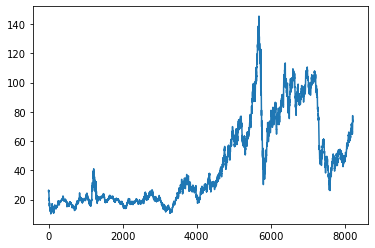

In [317]:
look_back=10
trainpredictPlot = np.empty_like(data_oil)
trainpredictPlot[:, :]= np.nan
trainpredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictplot = np.empty_like(data_oil)
testPredictplot[:,: ] = np.nan
testPredictplot[look_back:len(test_predict)+look_back, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data_oil))
plt.show()


In [318]:
len(test_data)


2876

In [319]:
x_input=test_data[2866:].reshape(1,-1)
x_input.shape


(1, 10)

In [320]:
temp_input=list(x_input) 
temp_input=temp_input[0].tolist()


In [321]:
temp_input


[0.44172960165852215,
 0.48111950244335855,
 0.49726047682511476,
 0.4679401747371539,
 0.4729749740855915,
 0.47119798608026064,
 0.47341922108692425,
 0.4649785280616022,
 0.4703835332444839,
 0.47149415074781587]

In [322]:
lst_output=[]
n_steps=10
i=0
while(i<10):
    if(len(temp_input)>10):
#print(temp_input)
       x_input=np.array(temp_input[1:]) 
       print("{} day input {}".format(i,x_input))
       x_input=x_input.reshape(1,-1)
       x_input = x_input.reshape((1, n_steps, 1)) #print(x_input)
       yhat = model.predict(x_input, verbose=0)
       print("{} day output {}".format(i,yhat))
       temp_input.extend(yhat[0].tolist())
       temp_input=temp_input[1:] #print(temp_input)
       lst_output.extend(yhat.tolist())
       i=i+1
    else:
       x_input = x_input.reshape((1, n_steps,1))
       yhat = model.predict(x_input, verbose=0)
       print(yhat[0])
       temp_input.extend(yhat[0].tolist()) 
       print(len(temp_input))
       lst_output.extend(yhat.tolist())
       i=i+1


[0.47207212]
11
1 day input [0.4811195  0.49726048 0.46794017 0.47297497 0.47119799 0.47341922
 0.46497853 0.47038353 0.47149415 0.47207212]
1 day output [[0.47570086]]
2 day input [0.49726048 0.46794017 0.47297497 0.47119799 0.47341922 0.46497853
 0.47038353 0.47149415 0.47207212 0.47570086]
2 day output [[0.47430834]]
3 day input [0.46794017 0.47297497 0.47119799 0.47341922 0.46497853 0.47038353
 0.47149415 0.47207212 0.47570086 0.47430834]
3 day output [[0.4710693]]
4 day input [0.47297497 0.47119799 0.47341922 0.46497853 0.47038353 0.47149415
 0.47207212 0.47570086 0.47430834 0.47106931]
4 day output [[0.47163424]]
5 day input [0.47119799 0.47341922 0.46497853 0.47038353 0.47149415 0.47207212
 0.47570086 0.47430834 0.47106931 0.47163424]
5 day output [[0.47158182]]
6 day input [0.47341922 0.46497853 0.47038353 0.47149415 0.47207212 0.47570086
 0.47430834 0.47106931 0.47163424 0.47158182]
6 day output [[0.47176063]]
7 day input [0.46497853 0.47038353 0.47149415 0.47207212 0.47570086

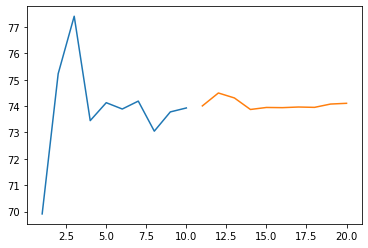

In [323]:
day_new=np.arange(1,11) 
day_pred=np.arange(11,21)
len(data_oil)
plt.plot(day_new, scaler.inverse_transform(data_oil[8206:])) 
plt.plot(day_pred, scaler.inverse_transform(lst_output))


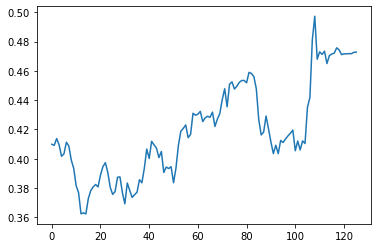

In [324]:
df3=data_oil.tolist() 
df3.extend(lst_output) 
plt.plot(df3[8100:])


In [325]:
df3=scaler.inverse_transform(df3).tolist()


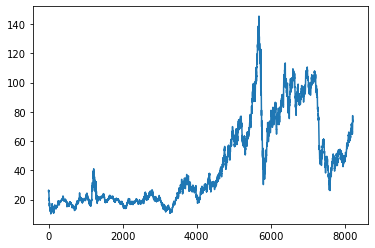

In [326]:
plt.plot(scaler.inverse_transform(data_oil))


In [327]:
!pip install ibm_watson_machine_learning

In [328]:
from ibm_watson_machine_learning import APIClient
wml_credentials = {
                    "url" : "https://us-south.ml.cloud.ibm.com",
                    "apikey":"WSp8hFmtltG36rU3Zdg0Ge_nb7dFP7x2Mbga7nL51334"
                }
client = APIClient(wml_credentials)

In [329]:
def guid_from_space_name(client, space_name):
    space = client.spaces.get_details()
    #print(space)
    return(next(item for item in space['resources'] if item['entity']["name"] == space_name)['metadata']['id'])

In [330]:
space_uid = guid_from_space_name(client, 'models')
print("Space UID = " + space_uid)

Space UID = c556d720-ab1b-498b-bf93-dd5316b6130f


In [331]:
client.set.default_space(space_uid)

'SUCCESS'

In [332]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt22.2-py3.10        125b6d9

In [335]:
software_spec_uid = client.software_specifications.get_uid_by_name("runtime-22.1-py3.9")
software_spec_uid

'12b83a17-24d8-5082-900f-0ab31fbfd3cb'

In [337]:
model_details = client.repository.store_model(model="project.tgz",meta_props={
client.repository.ModelMetaNames.NAME: "Crude_modeling",
client.repository.ModelMetaNames.TYPE: "scikit-learn_1.0",
client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_spec_uid}
                                             )
model_id = client.repository.get_model_id(model_details)

In [338]:
model_id


'd755d621-f7bd-46df-b8e2-52ab1a7a2fa6'